In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from copy import deepcopy

import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from tqdm import tqdm
from tempfile import TemporaryDirectory

import warnings

In [3]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

In [4]:
import sys
sys.path.append("..")

In [68]:
# Import the various experiments we need for the notebook
from sva.experiments import NegatedGramacyLee2012, get_dreamed_experiment

# Import the helper functions for Gaussian Processes
from sva.models.gp import EasySingleTaskGP

# Import ask utility for Bayesian Optimization
from sva.models.gp.bo import ask

# Import seed all utility
from sva.utils import seed_everything

# Import ask utility for Bayesian Optimization
from sva.models.gp.campaign import run_simple_campaign

# An even simpler 1d example

Before running a true campaign, let's begin by seeing how using a simple acquisition function produces reasonable results on a simple test function, Grammacy Lee 2012, which can be found [here](https://www.sfu.ca/~ssurjano/grlee12.html).

References:

- Gramacy, R. B., & Lee, H. K. (2012). Cases for the nugget in modeling computer experiments. Statistics and Computing, 22(3), 713-722.
- Ranjan, P. (2013). Comment: EI Criteria for Noisy Computer Simulators. Technometrics, 55(1), 24-28.

In [118]:
seed_everything(1234)

In [119]:
experiment = NegatedGramacyLee2012()
experiment.initialize_data(n=3, protocol="random", seed=124)

In [120]:
x = experiment.get_dense_coordinates(ppd=1000)
y = experiment(x)

Here's a plot of the negated Grammacy Lee function along with it's true maximum found via `scipy.optimize`. Numerically, the true maximum of this function occurs at $x=0.548563$ with value $f(x) = 0.869011.$

In [121]:
grammacylee_max = 0.54856
grammacylee_max_value = 0.86901

In [122]:
gp = EasySingleTaskGP.from_default(experiment.data.X, experiment.data.Y)
gp.fit_mll()

{'elapsed': 0.039910375024192035}

In [123]:
mu, var = gp.predict(x)

In [124]:
gp_optimize_result = gp.optimize(experiment=experiment)

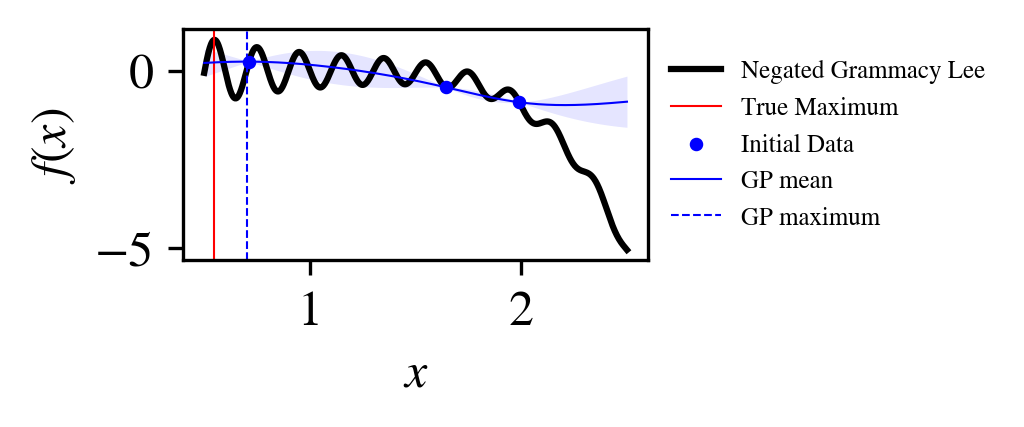

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1))

ax.plot(x, y, "k-", label="Negated Grammacy Lee")
ax.axvline(grammacylee_max, color="red", linewidth=0.5, label="True Maximum")

ax.scatter(experiment.data.X, experiment.data.Y, zorder=3, s=5, color="blue", label="Initial Data")
ax.plot(x, mu, color="blue", linewidth=0.5, label="GP mean")
ax.fill_between(x.squeeze(), mu - 2.0 * np.sqrt(var), mu + 2.0 * np.sqrt(var), color="blue", alpha=0.1, linewidth=0)
ax.axvline(gp_optimize_result["next_points"], color="blue", linestyle="--", linewidth=0.5, label="GP maximum")

ax.legend(fontsize=6, frameon=False, bbox_to_anchor=(1.0, 0.5), loc="center left")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
plt.show()

The objective will of course be to recover this maximum using Bayesian Optimization. Let's give this a try.

In [ ]:
seed_everything(1234)

experiment = NegatedGramacyLee2012()
experiment.initialize_data(n=3, protocol="random", seed=124)

# Set the total number of experiments
max_experiments = 100
acquisition_function = "UCB"
acquisition_function_kwargs={"beta": 10.0}
optimize_acqf_kwargs={"q": 1, "num_restarts": 20, "raw_samples": 100}

# Run
for ii in tqdm(range(max_experiments)):

    # Get the data
    X = experiment.data.X
    Y = experiment.data.Y

    if X.shape[0] > max_experiments:
        break

    gp = EasySingleTaskGP.from_default(X, Y)
    gp.fit_mll()

    # Ask the model what to do next
    if acquisition_function in ["EI", "qEI"]:
        acquisition_function_kwargs["best_f"] = Y.max()
    state = ask(
        gp.model,
        acquisition_function,
        bounds=experiment.properties.experimental_domain,
        acquisition_function_kwargs=acquisition_function_kwargs,
        optimize_acqf_kwargs=optimize_acqf_kwargs,
    )

    # Update the internal data store with the next points
    X2 = state["next_points"]
    experiment.update_data(X2)

    # Append the history with everything we want to keep
    # Note that the complete state of the GP is saved in the
    # acquisition function model
    optimize_result = gp.optimize(experiment=experiment, num_restarts=100, raw_samples=100)
    optimize_result.pop("acquisition_function")
    experiment.history.append(
        {
            "iteration": ii,
            "next_points": state["next_points"],
            "value": state["value"],
            "acquisition_function": deepcopy(state["acquisition_function"]),
            "optimize_gp_results": optimize_result,
            "easy_gp": deepcopy(gp),
        }
    )

In [130]:
last_gp = experiment.history.history[-1]["easy_gp"]
mu, var = last_gp.predict(x)

In [133]:
gp_maxima = [r["optimize_gp_results"]["next_points"].item() for r in experiment.history.history]

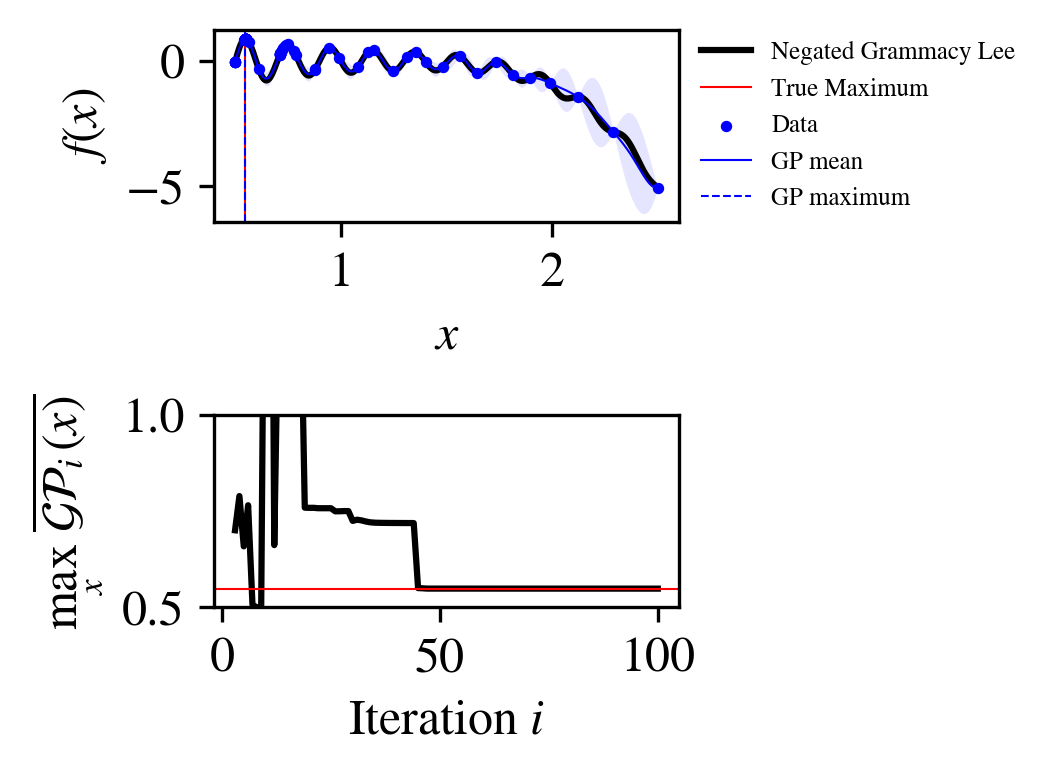

In [134]:
fig, axs = plt.subplots(2, 1, figsize=(2, 2.5))

ax = axs[0]
ax.plot(x, y, "k-", label="Negated Grammacy Lee")
ax.axvline(grammacylee_max, color="red", linewidth=0.5, label="True Maximum")

ax.scatter(experiment.data.X[:-1, :], experiment.data.Y[:-1, :], zorder=3, s=3, color="blue", label="Data")
ax.plot(x, mu, color="blue", linewidth=0.5, label="GP mean")
ax.fill_between(x.squeeze(), mu - 2.0 * np.sqrt(var), mu + 2.0 * np.sqrt(var), color="blue", alpha=0.1, linewidth=0)
ax.axvline(gp_maxima[-1], color="blue", linestyle="--", linewidth=0.5, label="GP maximum")

ax.legend(fontsize=6, frameon=False, bbox_to_anchor=(1.0, 0.5), loc="center left")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")

ax = axs[1]
ax.plot(np.arange(len(gp_maxima)) + 3, gp_maxima, "k-")
ax.axhline(grammacylee_max, linestyle="-", color="red", linewidth=0.5)
ax.set_ylabel("$\max_x~\overline{\mathcal{GP}_i(x)}$")
ax.set_xlabel("Iteration $i$")
ax.set_ylim(0.5, 1)

plt.subplots_adjust(hspace=1)
plt.show()

It can also be instructive to take a look at how the GP looks at each step.

In [232]:
ii = 50
history = experiment.history.history[ii]
print(history["next_points"])

tensor([[0.5488]])


In [233]:
mu, var = history["easy_gp"].predict(x)
acqf = history["acquisition_function"](torch.tensor(x).reshape(-1, 1, 1)).detach().numpy()
X, Y = experiment.data.X[:ii+4, :], experiment.data.Y[:ii+4, :]

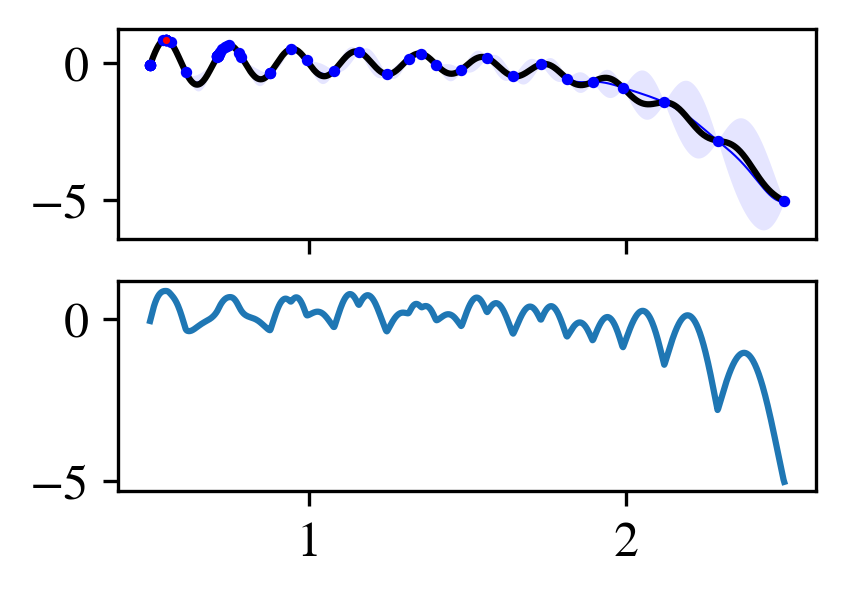

In [234]:
fig, axs = plt.subplots(2, 1, figsize=(3, 2), sharex=True)

ax = axs[0]
Y = experiment(X)
ax.scatter(X[:-1, :], Y[:-1, :], zorder=3, s=3, color="blue", label="Data")
ax.scatter(X[-1, :], Y[-1, :], zorder=3, s=0.5, color="red")
ax.plot(x, mu, color="blue", linewidth=0.5, label="GP mean")
ax.fill_between(x.squeeze(), mu - 2.0 * np.sqrt(var), mu + 2.0 * np.sqrt(var), color="blue", alpha=0.1, linewidth=0)
ax.plot(x, y, "k-", label="Negated Grammacy Lee")

ax = axs[1]
ax.plot(x, acqf)

plt.show()

Great, looks like it's more or less doing what it's supposed to be doing, but how do we know that we chose the optimal acquisition function? We can run a "simulated campaign". How does this work?

Let's say we fix the acquisition function to the Upper Confidence Bound with $\beta=10.$ For this acquisition function, we perform the following steps given a starting dataset (of maybe a handful of points).

1. Fit a GP to this data.
2. Sample a single instance from that GP, and fit _that_ single instance to some helper function (which could definitely be another GP). This single sample of the GP is going to be our source of truth.
3. Run the Bayesian Optimization campaign treating this helper as the source of truth. In principle, if your assumptions about smoothness are correct, this sampling should be, in principle, a possible experiment.
4. Log the progress of this campaign, taking careful note that the maximum value achieved is not the maximum sampled point, but the maximum of the GP used to fit the data.
5. Repeat steps 2-4 for a statistically relevant number of samples. This will put errorbars on step 4.

Once this has been performed, choose another acquisition function and repeat. We then want to compare which acquisition function achieves us the maximum the fastest. Note that this simulated campaign can (and probably should) be run many times throughout the real campaign.

In [6]:
seed_everything(1236)

experiment = NegatedGramacyLee2012()
experiment.initialize_data(n=3, protocol="random")
gp = EasySingleTaskGP.from_default(experiment.data.X, experiment.data.Y)
gp.fit_mll()
x = experiment.get_dense_coordinates(ppd=100)

campaign_results_list = []
acquisition_function_list = ["EI", "UCB", "UCB", "UCB"]
acquisition_function_kwargs_list = [{}, {"beta": 2.0}, {"beta": 20.0}, {"beta": 100.0}]

optimize_acqf_kwargs={"q": 1, "num_restarts": 20, "raw_samples": 100}
max_experiments = 25
max_dreams = 10

In [7]:
for acquisition_function, acquisition_function_kwargs in zip(
    acquisition_function_list, acquisition_function_kwargs_list
):
    result = {
        "acquisition_function": acquisition_function,
        "acquisition_function_kwargs": acquisition_function_kwargs,
        "dream_experiments": [],
        "dream_maxima": [],
    }
    
    for dream_index in range(max_dreams):
        
        dream_experiment = get_dreamed_experiment(experiment.data.X, experiment.data.Y, experiment.properties.experimental_domain)
        dream_max = dream_experiment.metadata["optima"]
        result["dream_maxima"].append(dream_max)
        
        for ii in tqdm(range(max_experiments)):
        
            # Get the data
            X = dream_experiment.data.X
            Y = dream_experiment.data.Y
        
            if X.shape[0] > max_experiments:
                break

            with warnings.catch_warnings(action="ignore"):
            
                gp = EasySingleTaskGP.from_default(X, Y)
                gp.fit_Adam()
            
                # Ask the model what to do next
                if acquisition_function in ["EI", "qEI"]:
                    acquisition_function_kwargs["best_f"] = Y.max()
                state = ask(
                    gp.model,
                    acquisition_function,
                    bounds=experjjiment.properties.experimental_domain,
                    acquisition_function_kwargs=acquisition_function_kwargs,
                    optimize_acqf_kwargs=optimize_acqf_kwargs,
                )
            
                # Update the internal data store with the next points
                X2 = state["next_points"]
                dream_experiment.update_data(X2)
            
                # Append the history with everything we want to keep
                # Note that the complete state of the GP is saved in the
                # acquisition function model
                optimize_result = gp.optimize(experiment=experiment, num_restarts=100, raw_samples=100)
                optimize_result.pop("acquisition_function")
                dream_experiment.history.append(
                    {
                        "iteration": ii,
                        "next_points": state["next_points"],
                        "value": state["value"],
                        "acquisition_function": deepcopy(state["acquisition_function"]),
                        "optimize_gp_results": optimize_result,
                        "easy_gp": deepcopy(gp),
                    }
                )
            
        result["dream_experiments"].append(dream_experiment)

    campaign_results_list.append(result)

 92%|███████████████████████████████████████████████████████████████████████████████████████████        | 23/25 [00:06<00:00,  3.81it/s]


In [8]:
optimize_gp_results = []
for ii in range(len(campaign_results_list)):
    dream_experiments = campaign_results_list[ii]["dream_experiments"]
    dream_maxima = campaign_results_list[ii]["dream_maxima"]
    
    tmp2 = []
    for dm, exp in zip(dream_maxima, dream_experiments):  # 5 exp

        # Get y^\star
        ystar = dm["value"] 

        tmp = []
        for item in exp.history.history:

            # get x^\star
            xstar = item["optimize_gp_results"]["next_points"].item()

            # Evaluate x^\star on the "truth"
            y_i_star = exp(np.array([[xstar]]))

            # compute opportunity cost
            opportunity_cost = np.abs(ystar - y_i_star) / np.abs(ystar)
            tmp.append(opportunity_cost)
        
        tmp2.append(tmp)
    optimize_gp_results.append(np.array(tmp2))

In [9]:
plot_kwargs = {
    'linewidth': 1.0,
    'marker': 's',
    'ms': 1.0,
    'capthick': 0.3,
    'capsize': 2.0,
    'elinewidth': 0.3
}

In [10]:
def legend_without_duplicate_labels(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    unique = [
	    (h, l) for i, (h, l) in enumerate(zip(handles, labels))
	    if l not in labels[:i]
	]
    ax.legend(*zip(*unique), **kwargs)

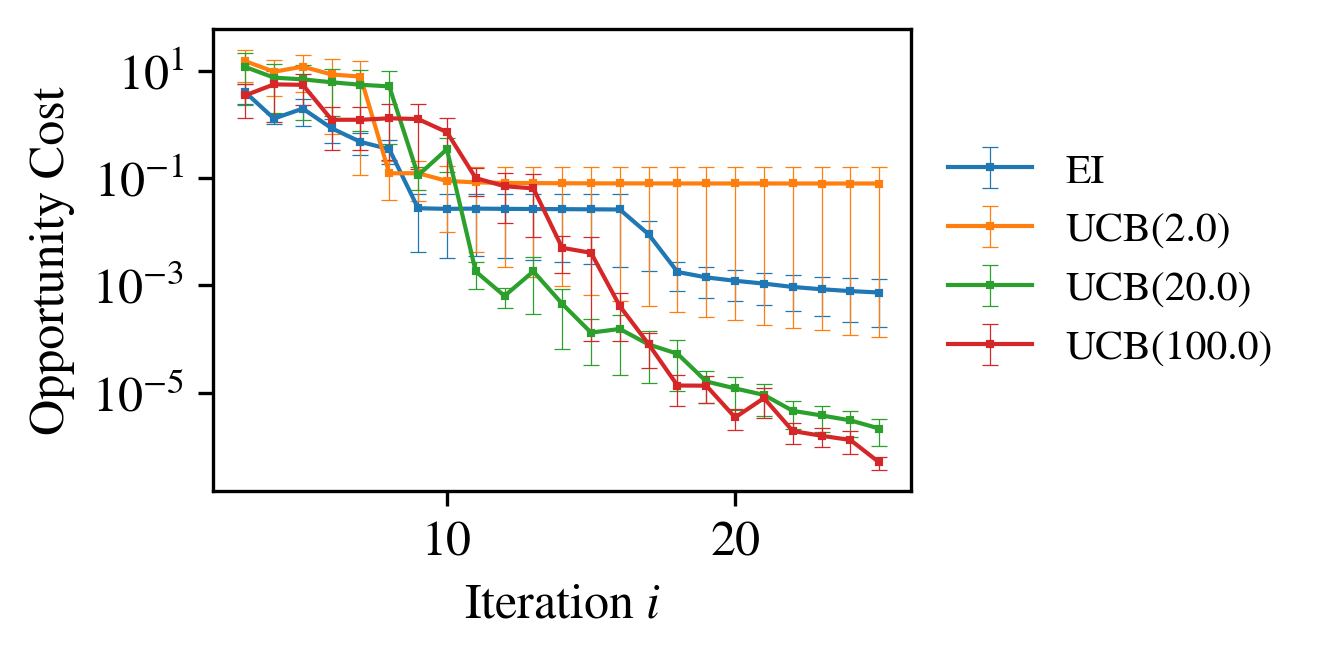

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
cmap = mpl.colormaps["rainbow"].resampled(len(campaign_results_list))

for ii, (campaign, optimize_gp_result) in enumerate(zip(campaign_results_list, optimize_gp_results)):
    acqf = campaign["acquisition_function"]
    beta = "" if acqf == "EI" else campaign["acquisition_function_kwargs"]["beta"]
    name = acqf if acqf == "EI" else f"{acqf}({beta:.01f})"

    

    mu = optimize_gp_result.mean(axis=0).squeeze()
    sd = optimize_gp_result.std(axis=0).squeeze()
    x = np.arange(len(mu)) + 3
    ax.errorbar(x, mu, yerr=sd/3, label=name, **plot_kwargs)

legend_without_duplicate_labels(ax, frameon=False, bbox_to_anchor=(1.0, 0.5), loc="center left")
ax.set_yscale("log")
ax.set_xlabel("Iteration $i$")
ax.set_ylabel("Opportunity Cost")
plt.show()

Let's take a look at a few of these examples.

In [114]:
acquisition_function_list = ["EI", "UCB", "UCB", "UCB"]
acquisition_function_kwargs_list = [{}, {"beta": 2.0}, {"beta": 10.0}, {"beta": 100.0}]
optimize_acqf_kwargs={"q": 1, "num_restarts": 20, "raw_samples": 100}

In [115]:
sample_experiments = []
for acquisition_function, acquisition_function_kwargs in zip(acquisition_function_list, acquisition_function_kwargs_list):
    seed_everything(1237)
    experiment = NegatedGramacyLee2012()
    experiment.initialize_data(n=3, protocol="random")
    run_simple_campaign(
        25,
        experiment,
        acquisition_function,
        acquisition_function_kwargs,
        optimize_acqf_kwargs,
        train_with="Adam",
    )
    sample_experiments.append(experiment)
    

 92%|███████████████████████████████████████████████████████████████████████████████████████████        | 23/25 [00:05<00:00,  4.40it/s]


In [116]:
points = []
for exp in sample_experiments:
    
    # This is the full list of sampled points
    last = exp.history.history[-1]["easy_gp"].X

    points.append(last)

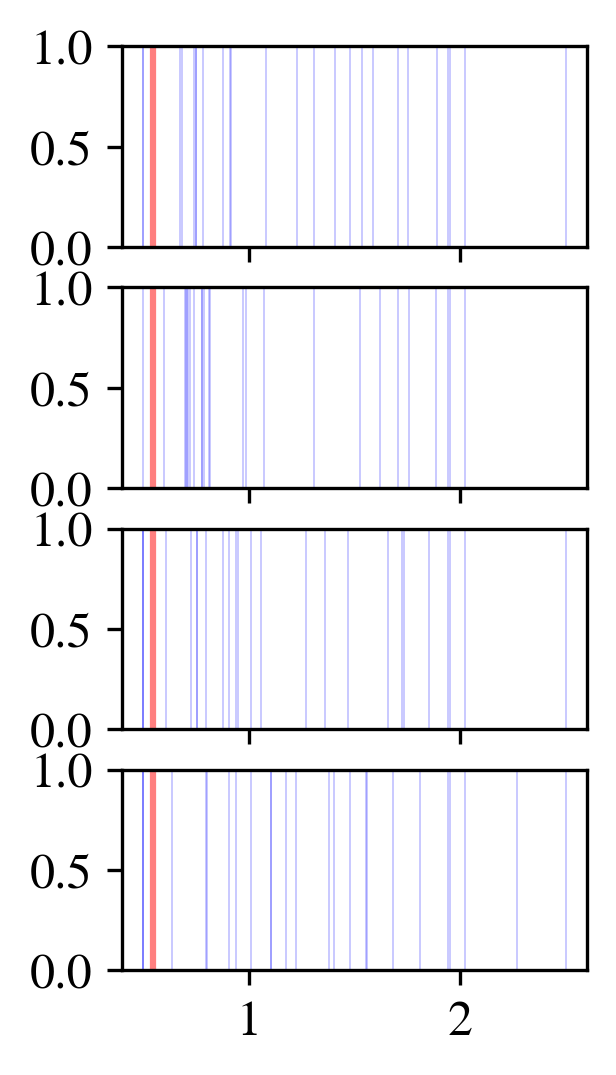

In [117]:
fig, axs = plt.subplots(4, 1, figsize=(2, 4), sharey=True, sharex=True)

for ii, last in enumerate(points):
    ax = axs[ii]

    ax.axvline(grammacylee_max, alpha=0.5, color="red")

    for s in last:
        ax.axvline(s, linewidth=0.1, color="blue")
    

GP is the innermost fit to the simulated data in the campaign 
"truth" - dummy truth sample
~~truth - we don't know~~

$y^\star$ == Find the max value of "truth"

1. Find the "best x" $x_i^\star$, argmax of the mean function of the GP at iteration i
2. $y_i^\star$ is the truth evaluated at $x_i^\star$
3. MAE == $(y^\star - y_i^\star) / y^\star$ (opportunity cost)